In [3]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 25.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [16]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta, timezone

import warnings
warnings.filterwarnings('ignore')

# Stock Price Prediction of Microsoft

In [4]:
stock_list = ['MSFT']
stock_prices = yf.download(stock_list,start = '2018-01-01',end = '2022-01-01',
                              interval='1d', prepost=True)
stock_prices["Average"] = (stock_prices["High"] + stock_prices["Low"])/2
stock_prices.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,81.698814,22483800,85.904999
2018-01-03,86.059998,86.510002,85.970001,86.349998,82.079018,26061400,86.240002
2018-01-04,86.589996,87.660004,86.570000,87.110001,82.801453,21912000,87.115002
2018-01-05,87.660004,88.410004,87.430000,88.190002,83.828026,23407100,87.920002
2018-01-08,88.199997,88.580002,87.599998,88.279999,83.913567,22113000,88.090000
2018-01-09,88.650002,88.730003,87.860001,88.220001,83.856537,19484300,88.295002
2018-01-10,87.860001,88.190002,87.410004,87.820000,83.476303,18652200,87.800003
2018-01-11,88.129997,88.129997,87.239998,88.080002,83.723465,17808900,87.684998
2018-01-12,88.669998,89.779999,88.449997,89.599998,85.168289,24271500,89.114998


In [12]:
stock_prices.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2021-12-17,320.880005,324.920013,317.250000,323.799988,323.799988,47750300,321.085007
2021-12-20,320.049988,322.799988,317.570007,319.910004,319.910004,28326500,320.184998
2021-12-21,323.290009,327.730011,319.799988,327.290009,327.290009,24740600,323.764999
2021-12-22,328.299988,333.609985,325.750000,333.200012,333.200012,24831500,329.679993
2021-12-23,332.750000,336.390015,332.730011,334.690002,334.690002,19617800,334.560013
2021-12-27,335.459991,342.480011,335.429993,342.450012,342.450012,19947000,338.955002
2021-12-28,343.149994,343.809998,340.320007,341.250000,341.250000,15661500,342.065002
2021-12-29,341.299988,344.299988,339.679993,341.950012,341.950012,15042000,341.989990
2021-12-30,341.910004,343.130005,338.820007,339.320007,339.320007,15994500,340.975006


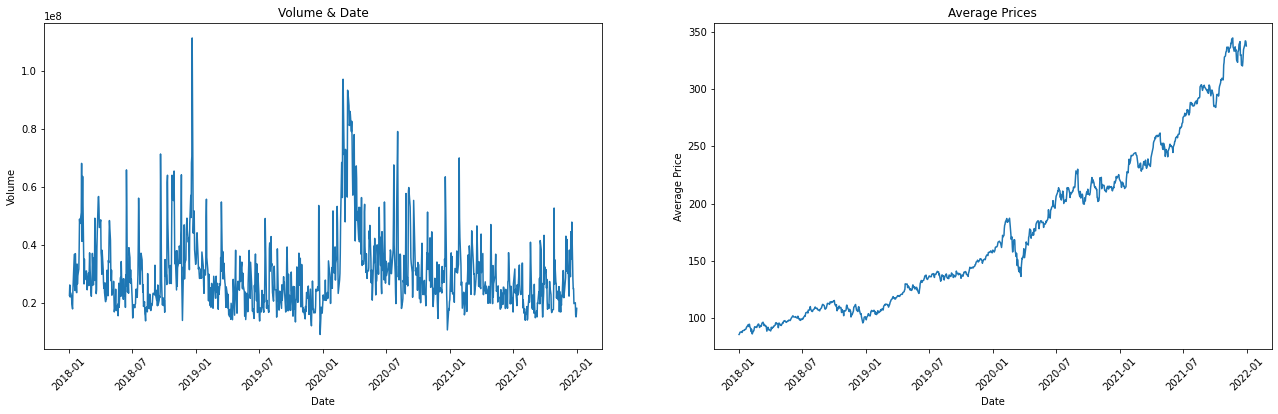

In [8]:
plt.figure(figsize=(22, 6))
plt.subplot(121)
sns.lineplot(x = stock_prices.index, y = stock_prices.Volume)
plt.title("Volume & Date")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.xticks(rotation = 45)

plt.subplot(122)
sns.lineplot(x = stock_prices.index, y = stock_prices.Average)
plt.title("Average Prices")
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.xticks(rotation = 45)

plt.show()

In [9]:
input_data = stock_prices.iloc[:,[5,6]].values

from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_data[:,:])

In [10]:
lookback= 50

test_size=int(.3 * len(stock_prices))
X=[]
y=[]
for i in range(len(stock_prices)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])

In [11]:
print(X[1][-1])
print(y[0])
print("-----------")
print(X[100][-1])
print(y[99])

[[0.18211513 0.03015018]]
0.030150182627128097
-----------
[[0.11028245 0.0853675 ]]
0.0853674993840865


In [13]:
X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)

(957, 50, 2)
(352, 50, 2)


In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [15]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 30)            3960      
                                                                 
 lstm_1 (LSTM)               (None, 50, 30)            7320      
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [17]:
model.fit(X, y, epochs=200, batch_size=32, verbose=0)


In [18]:
predictions= model.predict(X_test)


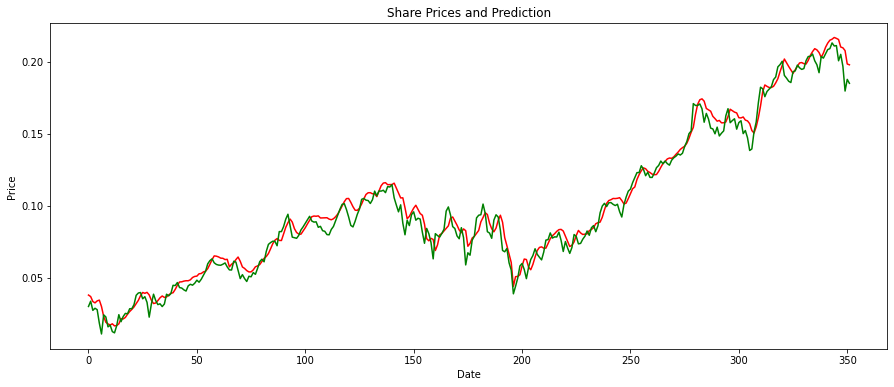

In [21]:
plt.figure(figsize=(15,6))
plt.plot(predictions, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Share Prices and Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# Stock Price Prediction of Tesla

In [23]:
stock_list = ['TSLA']
stock_prices = yf.download(stock_list,start = '2018-01-01',end = '2022-01-01',
                              interval='1d', prepost=True)
stock_prices["Average"] = (stock_prices["High"] + stock_prices["Low"])/2
stock_prices.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2018-01-02,62.400002,64.421997,62.200001,64.106003,64.106003,21761000,63.310999
2018-01-03,64.199997,65.050003,63.110001,63.450001,63.450001,22607500,64.080002
2018-01-04,62.574001,63.709999,61.136002,62.924000,62.924000,49731500,62.423000
2018-01-05,63.324001,63.448002,62.400002,63.316002,63.316002,22956000,62.924002
2018-01-08,63.200001,67.403999,63.099998,67.281998,67.281998,49297000,65.251999
2018-01-09,67.031998,67.760002,65.480003,66.737999,66.737999,35733000,66.620003
2018-01-10,66.440002,67.400002,66.000000,66.959999,66.959999,21549500,66.700001
2018-01-11,67.047997,68.961998,66.652000,67.589996,67.589996,33227500,67.806999
2018-01-12,67.725998,68.082001,66.734001,67.244003,67.244003,24125500,67.408001


In [24]:
stock_prices.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2021-12-17,914.770020,960.659973,909.039978,932.570007,932.570007,33479100,934.849976
2021-12-20,910.700012,921.690002,893.390015,899.940002,899.940002,18826700,907.540009
2021-12-21,916.869995,939.500000,886.119995,938.530029,938.530029,23839300,912.809998
2021-12-22,965.659973,1015.659973,957.049988,1008.869995,1008.869995,31211400,986.354980
2021-12-23,1006.799988,1072.979980,997.559998,1067.000000,1067.000000,30904400,1035.269989
2021-12-27,1073.670044,1117.000000,1070.719971,1093.939941,1093.939941,23715300,1093.859985
2021-12-28,1109.489990,1119.000000,1078.420044,1088.469971,1088.469971,20108000,1098.710022
2021-12-29,1098.640015,1104.000000,1064.140015,1086.189941,1086.189941,18718000,1084.070007
2021-12-30,1061.329956,1095.550049,1053.150024,1070.339966,1070.339966,15680300,1074.350037


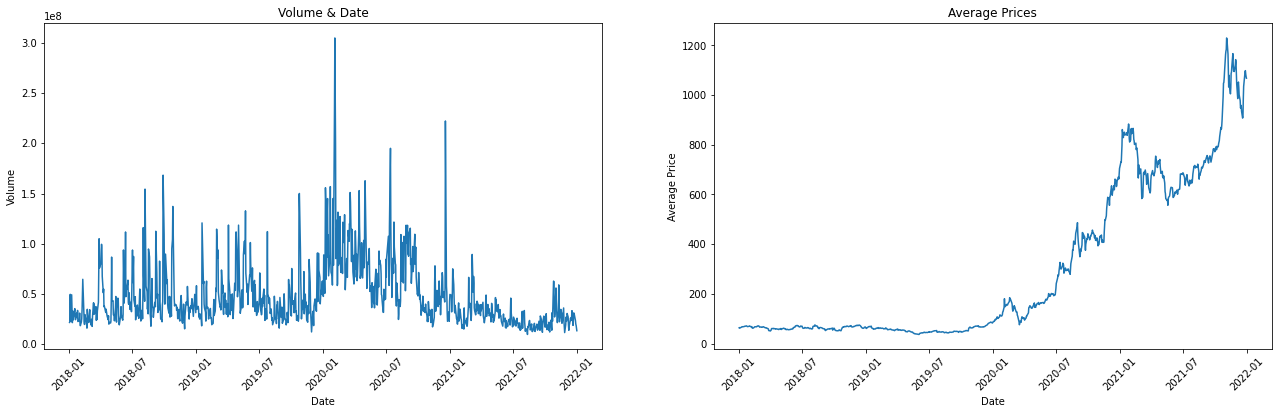

In [25]:
plt.figure(figsize=(22, 6))
plt.subplot(121)
sns.lineplot(x = stock_prices.index, y = stock_prices.Volume)
plt.title("Volume & Date")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.xticks(rotation = 45)

plt.subplot(122)
sns.lineplot(x = stock_prices.index, y = stock_prices.Average)
plt.title("Average Prices")
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.xticks(rotation = 45)

plt.show()

In [26]:
input_data = stock_prices.iloc[:,[5,6]].values

from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_data[:,:])

In [27]:
lookback= 50

test_size=int(.3 * len(stock_prices))
X=[]
y=[]
for i in range(len(stock_prices)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])

In [28]:
print(X[1][-1])
print(y[0])
print("-----------")
print(X[100][-1])
print(y[99])

[[0.07807364 0.02431404]]
0.024314043706075487
-----------
[[0.11197572 0.02790319]]
0.027903187538336895


In [29]:
X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)

(957, 50, 2)
(352, 50, 2)


In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [31]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 30)            3960      
                                                                 
 lstm_4 (LSTM)               (None, 50, 30)            7320      
                                                                 
 lstm_5 (LSTM)               (None, 30)                7320      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [33]:
model.fit(X, y, epochs=200, batch_size=32, verbose=0)


In [34]:
predictions= model.predict(X_test)


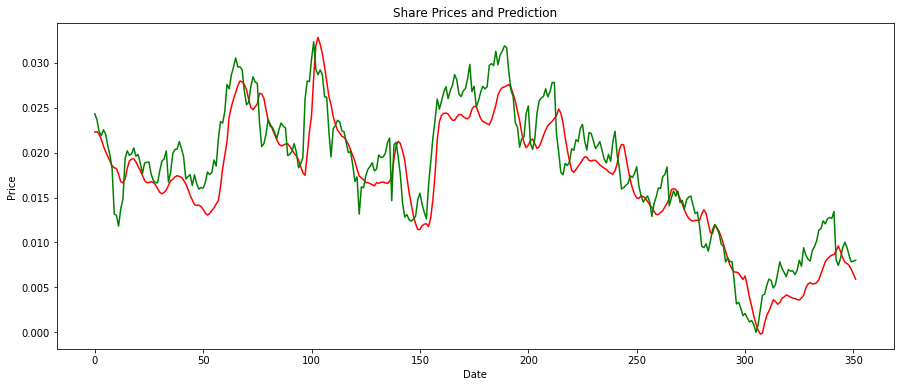

In [35]:
plt.figure(figsize=(15,6))
plt.plot(predictions, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Share Prices and Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# BTC-USD

In [ ]:
# I just wanted to see how can I use these approaches on Bitcoin below. One can disregard this section.

In [38]:
stock_list = ['BTC-USD']
stock_prices = yf.download(stock_list,start = '2020-01-01',end = '2022-01-01',
                              interval='1d', prepost=True)
stock_prices["Average"] = (stock_prices["High"] + stock_prices["Low"])/2
stock_prices.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997,7214.637451
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465,7073.712646
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032,7164.355713
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275,7368.449951
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095,7472.516357
2020-01-06,7410.452148,7781.867188,7409.292969,7769.219238,7769.219238,23276261598,7595.580078
2020-01-07,7768.682129,8178.215820,7768.227539,8163.692383,8163.692383,28767291327,7973.221680
2020-01-08,8161.935547,8396.738281,7956.774414,8079.862793,8079.862793,31672559265,8176.756348
2020-01-09,8082.295898,8082.295898,7842.403809,7879.071289,7879.071289,24045990466,7962.349854


In [39]:
stock_prices.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2021-12-23,48626.343750,51332.339844,48065.835938,50784.539062,50784.539062,28223878108,49699.087891
2021-12-24,50806.050781,51814.027344,50514.496094,50822.195312,50822.195312,24367912228,51164.261719
2021-12-25,50854.917969,51176.597656,50236.707031,50429.859375,50429.859375,19030650914,50706.652344
2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625,50809.515625,20964372926,50409.742188
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,51227.898438
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,49047.035156
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,47160.619141
2021-12-30,46490.605469,47879.964844,46060.312500,47178.125000,47178.125000,26686491018,46970.138672
2021-12-31,47169.371094,48472.527344,45819.953125,46306.445312,46306.445312,36974172400,47146.240234


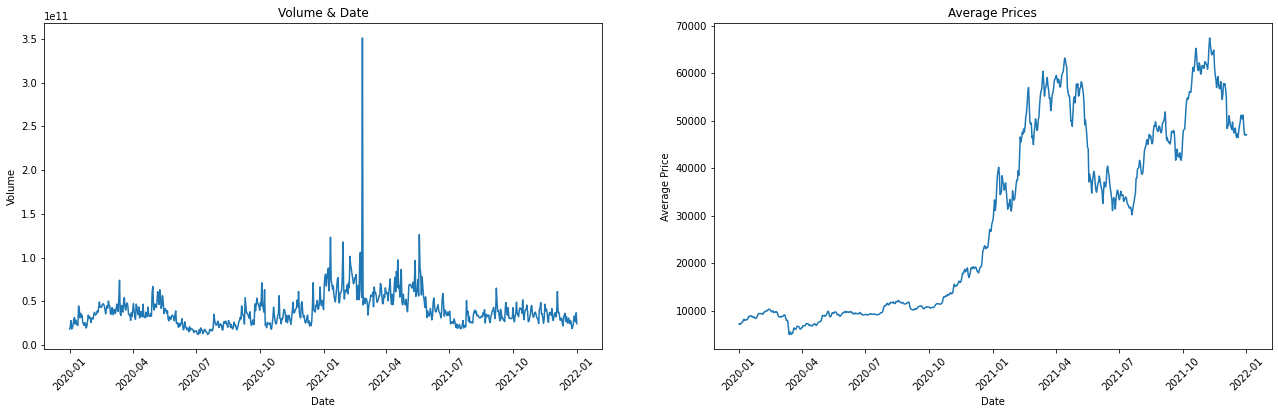

In [40]:
plt.figure(figsize=(22, 6))
plt.subplot(121)
sns.lineplot(x = stock_prices.index, y = stock_prices.Volume)
plt.title("Volume & Date")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.xticks(rotation = 45)

plt.subplot(122)
sns.lineplot(x = stock_prices.index, y = stock_prices.Average)
plt.title("Average Prices")
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.xticks(rotation = 45)

plt.show()

In [41]:
input_data = stock_prices.iloc[:,[5,6]].values

from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_data[:,:])

In [42]:
lookback= 50

test_size=int(.3 * len(stock_prices))
X=[]
y=[]
for i in range(len(stock_prices)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])

In [43]:
print(X[1][-1])
print(y[0])
print("-----------")
print(X[100][-1])
print(y[99])

[[0.09646052 0.07366744]]
0.07366744166626459
-----------
[[0.06094805 0.07208214]]
0.07208213636007506


In [44]:
X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)

(681, 50, 2)
(269, 50, 2)


In [45]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [46]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 30)            3960      
                                                                 
 lstm_7 (LSTM)               (None, 50, 30)            7320      
                                                                 
 lstm_8 (LSTM)               (None, 30)                7320      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [48]:
model.fit(X, y, epochs=200, batch_size=32, verbose=0)


In [49]:
predictions= model.predict(X_test)


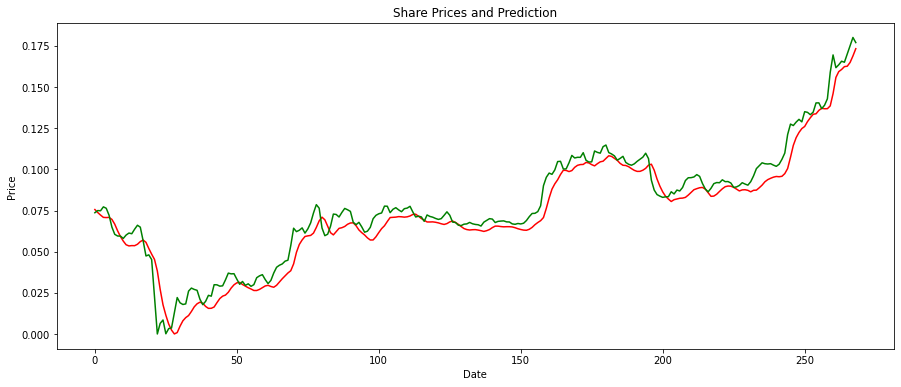

In [50]:
plt.figure(figsize=(15,6))
plt.plot(predictions, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Share Prices and Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# 2nd Question

In RNN, we still consider the features that includes from the very beginning such as the introduction section from a book, where we're trying to figure out what's going to happen at the end.
Hence, one needs to check the features that are closer to what we're trying to predict.

# Predictions with Different Epochs and Batch Sizes

The batch size is a number of samples processed before the model is updated.

The number of epochs is the number of complete passes through the training dataset.

Also, the size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset.

In [ ]:
# Microsoft Stock Prices with different epochs and batch_sizes

In [17]:
stock_list = ['MSFT']
stock_prices = yf.download(stock_list,start = '2018-01-01',end = '2022-01-01',
                              interval='1d', prepost=True)
stock_prices["Average"] = (stock_prices["High"] + stock_prices["Low"])/2
stock_prices.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,81.698814,22483800,85.904999
2018-01-03,86.059998,86.510002,85.970001,86.349998,82.079033,26061400,86.240002
2018-01-04,86.589996,87.660004,86.570000,87.110001,82.801437,21912000,87.115002
2018-01-05,87.660004,88.410004,87.430000,88.190002,83.828026,23407100,87.920002
2018-01-08,88.199997,88.580002,87.599998,88.279999,83.913574,22113000,88.090000
2018-01-09,88.650002,88.730003,87.860001,88.220001,83.856544,19484300,88.295002
2018-01-10,87.860001,88.190002,87.410004,87.820000,83.476318,18652200,87.800003
2018-01-11,88.129997,88.129997,87.239998,88.080002,83.723465,17808900,87.684998
2018-01-12,88.669998,89.779999,88.449997,89.599998,85.168282,24271500,89.114998


In [18]:
stock_prices.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2021-12-17,320.880005,324.920013,317.250000,323.799988,323.799988,47750300,321.085007
2021-12-20,320.049988,322.799988,317.570007,319.910004,319.910004,28326500,320.184998
2021-12-21,323.290009,327.730011,319.799988,327.290009,327.290009,24740600,323.764999
2021-12-22,328.299988,333.609985,325.750000,333.200012,333.200012,24831500,329.679993
2021-12-23,332.750000,336.390015,332.730011,334.690002,334.690002,19617800,334.560013
2021-12-27,335.459991,342.480011,335.429993,342.450012,342.450012,19947000,338.955002
2021-12-28,343.149994,343.809998,340.320007,341.250000,341.250000,15661500,342.065002
2021-12-29,341.299988,344.299988,339.679993,341.950012,341.950012,15042000,341.989990
2021-12-30,341.910004,343.130005,338.820007,339.320007,339.320007,15994500,340.975006


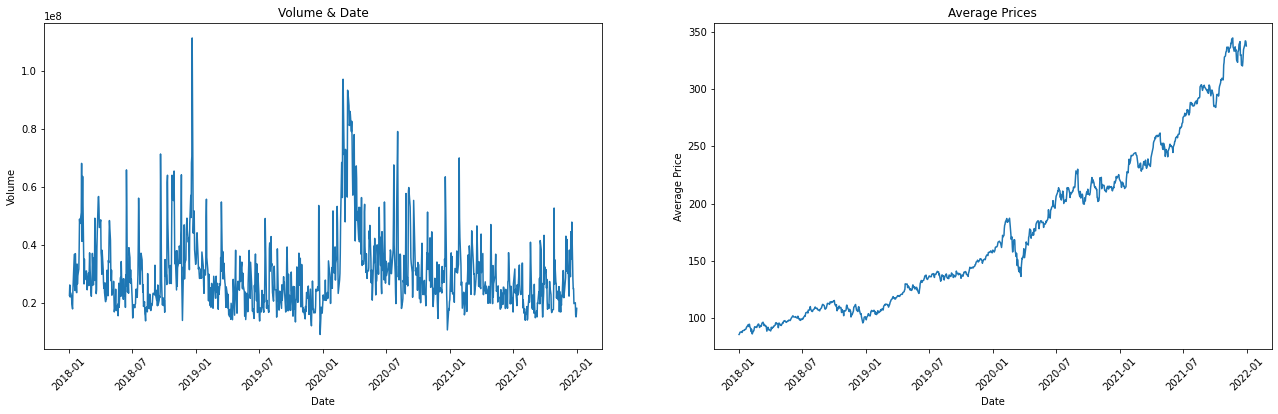

In [19]:
plt.figure(figsize=(22, 6))
plt.subplot(121)
sns.lineplot(x = stock_prices.index, y = stock_prices.Volume)
plt.title("Volume & Date")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.xticks(rotation = 45)

plt.subplot(122)
sns.lineplot(x = stock_prices.index, y = stock_prices.Average)
plt.title("Average Prices")
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.xticks(rotation = 45)

plt.show()

In [20]:
input_data = stock_prices.iloc[:,[5,6]].values

from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_data[:,:])

In [21]:
lookback= 50

test_size=int(.3 * len(stock_prices))
X=[]
y=[]
for i in range(len(stock_prices)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])

In [22]:
print(X[1][-1])
print(y[0])
print("-----------")
print(X[100][-1])
print(y[99])

[[0.18211513 0.03015018]]
0.030150182627128097
-----------
[[0.11028245 0.0853675 ]]
0.0853674993840865


In [23]:
X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)

(957, 50, 2)
(352, 50, 2)


In [24]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [25]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 30)            3960      
                                                                 
 lstm_4 (LSTM)               (None, 50, 30)            7320      
                                                                 
 lstm_5 (LSTM)               (None, 30)                7320      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='adam', loss='mean_squared_error')

Model with not 200 but 300 epochs, we'll try to decrease the batch_size later.

In [27]:
model.fit(X, y, epochs=300, batch_size=32, verbose=0)

In [28]:
predictions= model.predict(X_test)


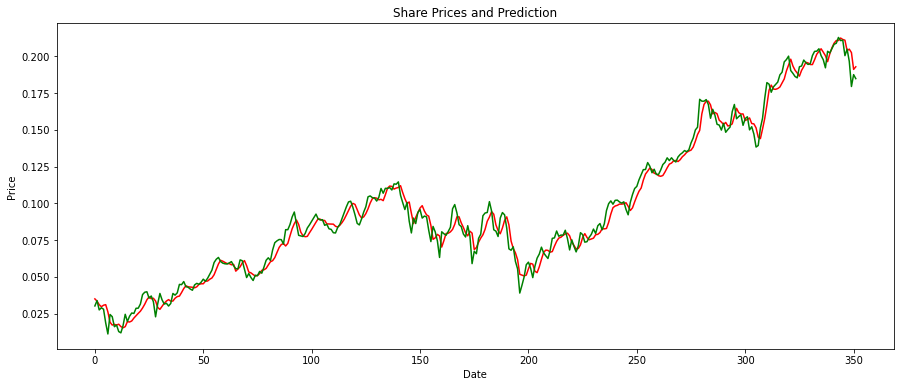

In [29]:
plt.figure(figsize=(15,6))
plt.plot(predictions, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Share Prices and Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [ ]:
# more epochs take more time, so I'll use lesser epochs this time

**Model with 100 epochs**

In [31]:
stock_list = ['MSFT']
stock_prices = yf.download(stock_list,start = '2018-01-01',end = '2022-01-01',
                              interval='1d', prepost=True)
stock_prices["Average"] = (stock_prices["High"] + stock_prices["Low"])/2
stock_prices.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,81.698814,22483800,85.904999
2018-01-03,86.059998,86.510002,85.970001,86.349998,82.079018,26061400,86.240002
2018-01-04,86.589996,87.660004,86.570000,87.110001,82.801437,21912000,87.115002
2018-01-05,87.660004,88.410004,87.430000,88.190002,83.828018,23407100,87.920002
2018-01-08,88.199997,88.580002,87.599998,88.279999,83.913574,22113000,88.090000
2018-01-09,88.650002,88.730003,87.860001,88.220001,83.856552,19484300,88.295002
2018-01-10,87.860001,88.190002,87.410004,87.820000,83.476326,18652200,87.800003
2018-01-11,88.129997,88.129997,87.239998,88.080002,83.723457,17808900,87.684998
2018-01-12,88.669998,89.779999,88.449997,89.599998,85.168297,24271500,89.114998


In [32]:
stock_prices.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2021-12-17,320.880005,324.920013,317.250000,323.799988,323.799988,47750300,321.085007
2021-12-20,320.049988,322.799988,317.570007,319.910004,319.910004,28326500,320.184998
2021-12-21,323.290009,327.730011,319.799988,327.290009,327.290009,24740600,323.764999
2021-12-22,328.299988,333.609985,325.750000,333.200012,333.200012,24831500,329.679993
2021-12-23,332.750000,336.390015,332.730011,334.690002,334.690002,19617800,334.560013
2021-12-27,335.459991,342.480011,335.429993,342.450012,342.450012,19947000,338.955002
2021-12-28,343.149994,343.809998,340.320007,341.250000,341.250000,15661500,342.065002
2021-12-29,341.299988,344.299988,339.679993,341.950012,341.950012,15042000,341.989990
2021-12-30,341.910004,343.130005,338.820007,339.320007,339.320007,15994500,340.975006


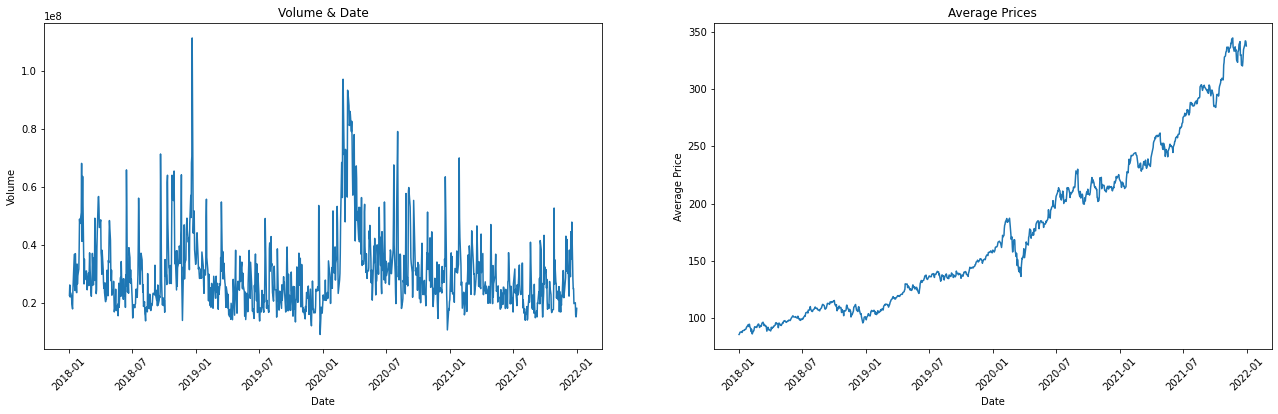

In [33]:
plt.figure(figsize=(22, 6))
plt.subplot(121)
sns.lineplot(x = stock_prices.index, y = stock_prices.Volume)
plt.title("Volume & Date")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.xticks(rotation = 45)

plt.subplot(122)
sns.lineplot(x = stock_prices.index, y = stock_prices.Average)
plt.title("Average Prices")
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.xticks(rotation = 45)

plt.show()

In [34]:
input_data = stock_prices.iloc[:,[5,6]].values

from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_data[:,:])

In [35]:
lookback= 50

test_size=int(.3 * len(stock_prices))
X=[]
y=[]
for i in range(len(stock_prices)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])

In [36]:
print(X[1][-1])
print(y[0])
print("-----------")
print(X[100][-1])
print(y[99])

[[0.18211513 0.03015018]]
0.030150182627128097
-----------
[[0.11028245 0.0853675 ]]
0.0853674993840865


In [37]:
X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)

(957, 50, 2)
(352, 50, 2)


In [38]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [39]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 30)            3960      
                                                                 
 lstm_7 (LSTM)               (None, 50, 30)            7320      
                                                                 
 lstm_8 (LSTM)               (None, 30)                7320      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [41]:
model.fit(X, y, epochs=100, batch_size=32, verbose=0)

In [42]:
predictions= model.predict(X_test)


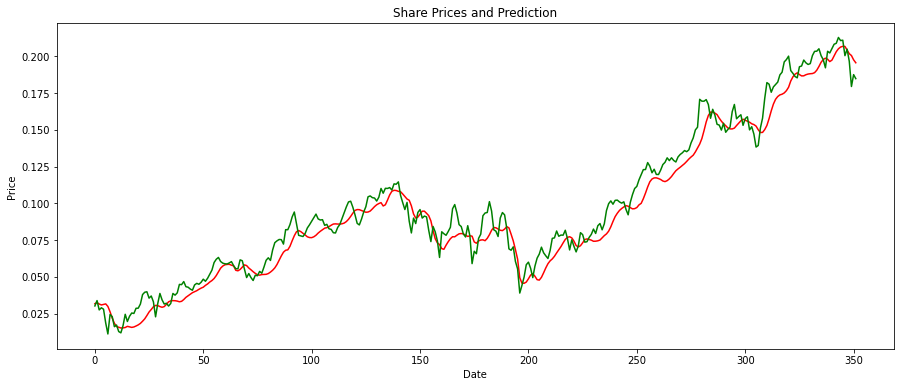

In [43]:
plt.figure(figsize=(15,6))
plt.plot(predictions, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Share Prices and Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

As you can see, with more epochs, we get closer to the real prices.

**Model with 100 epochs, but with greater batch_size**

In [44]:
stock_list = ['MSFT']
stock_prices = yf.download(stock_list,start = '2018-01-01',end = '2022-01-01',
                              interval='1d', prepost=True)
stock_prices["Average"] = (stock_prices["High"] + stock_prices["Low"])/2
stock_prices.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,81.698814,22483800,85.904999
2018-01-03,86.059998,86.510002,85.970001,86.349998,82.079025,26061400,86.240002
2018-01-04,86.589996,87.660004,86.570000,87.110001,82.801437,21912000,87.115002
2018-01-05,87.660004,88.410004,87.430000,88.190002,83.828018,23407100,87.920002
2018-01-08,88.199997,88.580002,87.599998,88.279999,83.913567,22113000,88.090000
2018-01-09,88.650002,88.730003,87.860001,88.220001,83.856537,19484300,88.295002
2018-01-10,87.860001,88.190002,87.410004,87.820000,83.476326,18652200,87.800003
2018-01-11,88.129997,88.129997,87.239998,88.080002,83.723473,17808900,87.684998
2018-01-12,88.669998,89.779999,88.449997,89.599998,85.168289,24271500,89.114998


In [45]:
stock_prices.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2021-12-17,320.880005,324.920013,317.250000,323.799988,323.799988,47750300,321.085007
2021-12-20,320.049988,322.799988,317.570007,319.910004,319.910004,28326500,320.184998
2021-12-21,323.290009,327.730011,319.799988,327.290009,327.290009,24740600,323.764999
2021-12-22,328.299988,333.609985,325.750000,333.200012,333.200012,24831500,329.679993
2021-12-23,332.750000,336.390015,332.730011,334.690002,334.690002,19617800,334.560013
2021-12-27,335.459991,342.480011,335.429993,342.450012,342.450012,19947000,338.955002
2021-12-28,343.149994,343.809998,340.320007,341.250000,341.250000,15661500,342.065002
2021-12-29,341.299988,344.299988,339.679993,341.950012,341.950012,15042000,341.989990
2021-12-30,341.910004,343.130005,338.820007,339.320007,339.320007,15994500,340.975006


In [47]:
input_data = stock_prices.iloc[:,[5,6]].values

from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_data[:,:])

In [48]:
lookback= 50

test_size=int(.3 * len(stock_prices))
X=[]
y=[]
for i in range(len(stock_prices)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])

In [49]:
print(X[1][-1])
print(y[0])
print("-----------")
print(X[100][-1])
print(y[99])

[[0.18211513 0.03015018]]
0.030150182627128097
-----------
[[0.11028245 0.0853675 ]]
0.0853674993840865


In [50]:
X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)

(957, 50, 2)
(352, 50, 2)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [51]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50, 30)            3960      
                                                                 
 lstm_10 (LSTM)              (None, 50, 30)            7320      
                                                                 
 lstm_11 (LSTM)              (None, 30)                7320      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [53]:
model.fit(X, y, epochs=100, batch_size=64, verbose=0)

In [54]:
predictions= model.predict(X_test)


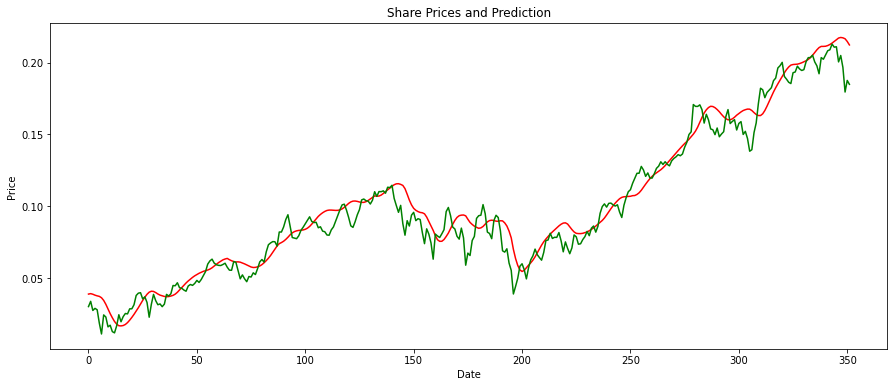

In [55]:
plt.figure(figsize=(15,6))
plt.plot(predictions, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Share Prices and Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

Greater the batch size, less accuracy of the model.

So we'll reduce the batch_size this time.

In [56]:
stock_list = ['MSFT']
stock_prices = yf.download(stock_list,start = '2018-01-01',end = '2022-01-01',
                              interval='1d', prepost=True)
stock_prices["Average"] = (stock_prices["High"] + stock_prices["Low"])/2
stock_prices.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,81.698822,22483800,85.904999
2018-01-03,86.059998,86.510002,85.970001,86.349998,82.079025,26061400,86.240002
2018-01-04,86.589996,87.660004,86.570000,87.110001,82.801453,21912000,87.115002
2018-01-05,87.660004,88.410004,87.430000,88.190002,83.828026,23407100,87.920002
2018-01-08,88.199997,88.580002,87.599998,88.279999,83.913559,22113000,88.090000
2018-01-09,88.650002,88.730003,87.860001,88.220001,83.856522,19484300,88.295002
2018-01-10,87.860001,88.190002,87.410004,87.820000,83.476318,18652200,87.800003
2018-01-11,88.129997,88.129997,87.239998,88.080002,83.723473,17808900,87.684998
2018-01-12,88.669998,89.779999,88.449997,89.599998,85.168282,24271500,89.114998


In [57]:
stock_prices.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2021-12-17,320.880005,324.920013,317.250000,323.799988,323.799988,47750300,321.085007
2021-12-20,320.049988,322.799988,317.570007,319.910004,319.910004,28326500,320.184998
2021-12-21,323.290009,327.730011,319.799988,327.290009,327.290009,24740600,323.764999
2021-12-22,328.299988,333.609985,325.750000,333.200012,333.200012,24831500,329.679993
2021-12-23,332.750000,336.390015,332.730011,334.690002,334.690002,19617800,334.560013
2021-12-27,335.459991,342.480011,335.429993,342.450012,342.450012,19947000,338.955002
2021-12-28,343.149994,343.809998,340.320007,341.250000,341.250000,15661500,342.065002
2021-12-29,341.299988,344.299988,339.679993,341.950012,341.950012,15042000,341.989990
2021-12-30,341.910004,343.130005,338.820007,339.320007,339.320007,15994500,340.975006


In [58]:
input_data = stock_prices.iloc[:,[5,6]].values

from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_data[:,:])

In [59]:
lookback= 50

test_size=int(.3 * len(stock_prices))
X=[]
y=[]
for i in range(len(stock_prices)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])

In [60]:
print(X[1][-1])
print(y[0])
print("-----------")
print(X[100][-1])
print(y[99])

[[0.18211513 0.03015018]]
0.030150182627128097
-----------
[[0.11028245 0.0853675 ]]
0.0853674993840865


In [61]:
X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)

(957, 50, 2)
(352, 50, 2)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [62]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 50, 30)            3960      
                                                                 
 lstm_13 (LSTM)              (None, 50, 30)            7320      
                                                                 
 lstm_14 (LSTM)              (None, 30)                7320      
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [64]:
model.fit(X, y, epochs=100, batch_size=16, verbose=0)

In [65]:
predictions= model.predict(X_test)


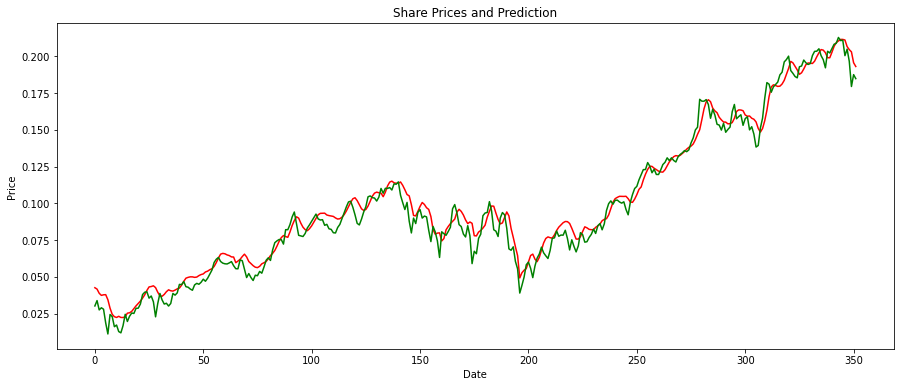

In [66]:
plt.figure(figsize=(15,6))
plt.plot(predictions, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Share Prices and Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

**One can see that lesser batch_size predicts the real stock price better than greater batch_size, if epochs are the same.**